# Ordered MNIST (jax)

We begin by getting the Ordered MNIST dataset from `kooplearn` and plotting a small sample out of it

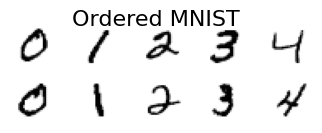

In [2]:
from kooplearn.datasets import fetch_ordered_mnist
import matplotlib.pyplot as plt
# We only use the digits 0 to 4
num_digits = 5
images, labels = fetch_ordered_mnist(num_digits=num_digits)
# Plot the data
fig, axs = plt.subplots(nrows=2, ncols=num_digits, figsize=(0.8*num_digits, 1.3))
for img, ax in zip(images, axs.ravel()):
    ax.imshow(img, cmap="Greys")
    ax.axis("off")
fig.suptitle("Ordered MNIST", fontsize=16)
plt.show()

We split the dataset into train/validation/test (3k points for training, 1k for testing and 1k for validation)

In [3]:
import numpy as np
# train images will be images[train_ids] and so on
train_ids, val_ids, test_ids = np.split(np.arange(5000), [3000, 4000])

This example closely follows the experiment from <cite data-footcite="Kostic2023DPNets">Kostic et al. 2024</cite>. Each koopman operator model trained will be validated as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time. We begin by defining the _oracle_ classifier

In [188]:
import jax
import jax.numpy as jnp
from flax import nnx
from flax.nnx.nn import initializers

from functools import partial


class CNNEncoder(nnx.Module):
    def __init__(self, num_classes: int, rngs: nnx.Rngs):
        # NHWC convention
        self.conv1 = nnx.Conv(1, 16, kernel_size=(5, 5), padding=2, rngs=rngs)
        self.conv2 = nnx.Conv(16, 32, kernel_size=(5, 5), padding=2, rngs=rngs)
        self.max_pool = partial(nnx.max_pool, window_shape=(2, 2), strides=(2, 2))
        self.lin_out = nnx.Linear(32 * 7 * 7, num_classes, rngs=rngs)

    def __call__(self, X):
        if X.ndim == 3:
            X = jnp.expand_dims(X, -1)
        X = self.max_pool(nnx.relu(self.conv1(X)))
        X = self.max_pool(nnx.relu(self.conv2(X)))
        X = X.reshape(X.shape[0], -1)  # Flatten
        out = self.lin_out(X)
        return out


class CNNDecoder(nnx.Module):
    def __init__(self, num_classes: int, rngs: nnx.Rngs):
        self.lin_proj = nnx.Linear(num_classes, 32 * 7 * 7, rngs=rngs)
        self.conv1 = nnx.ConvTranspose(32, 16, kernel_size=(5, 5), padding=2, rngs=rngs)
        self.conv2 = nnx.ConvTranspose(16, 1, kernel_size=(5, 5), padding=2, rngs=rngs)

    def upsample(self, X, scale_factor: int = 2):
        N, H, W, C = X.shape
        X_upsampled = jax.image.resize(
            X, (N, H * scale_factor, W * scale_factor, C), method="bilinear"
        )
        return X_upsampled

    def __call__(self, X):
        X = self.lin_proj(X)
        X = X.reshape(X.shape[0], 7, 7, 32)
        X = self.conv1(nnx.relu(self.upsample(X)))
        X = self.conv2(nnx.relu(self.upsample(X)))
        # Remove last dim
        X = jnp.squeeze(X)
        return X


def make_dataloader(*arrays, batch_size, shuffle=False):
    """
    Minimal data loader function that iterates over batches of NumPy arrays.

    Args:
        *arrays: A variable number of NumPy arrays. All arrays must have
                 the same size in the first dimension.
        batch_size (int): The size of each batch.
        shuffle (bool): Whether to shuffle the data before iterating.

    Yields:
        A tuple of batched arrays.
    """
    if not arrays:
        return

    # Get the total number of samples from the first array
    num_samples = arrays[0].shape[0]

    # Validate that all arrays have the same first dimension
    for arr in arrays[1:]:
        if arr.shape[0] != num_samples:
            raise ValueError(
                "All arrays must have the same size in the first dimension."
            )

    # Create an array of indices
    indices = np.arange(num_samples)

    # Shuffle indices if requested
    if shuffle:
        # Use NumPy's random generator for shuffling CPU-side indices
        rng = np.random.default_rng()
        rng.shuffle(indices)

    # Yield batches
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]

        # Yield a tuple of slices from each array
        yield tuple(arr[batch_indices] for arr in arrays)

In [171]:
import optax


def train_oracle_classifier():
    num_epochs = 20
    # Prepare data
    X_train = images[train_ids]
    labels_train = labels[train_ids]
    X_val = images[val_ids]
    labels_val = labels[val_ids]
    # Define model and optimizer
    rngs = nnx.Rngs(0)
    oracle = CNNEncoder(num_classes=num_digits, rngs=rngs)
    nnx.display(oracle)

    optimizer = nnx.Optimizer(oracle, optax.adamw(8e-4, weight_decay=0.01), wrt=nnx.Param)
    metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average("loss"),
    )

    def loss_fn(model: CNNEncoder, batch):
        images, labels = batch
        logits = model(images)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=labels
        ).mean()
        return loss, logits

    @nnx.jit
    def train_step(
        model: CNNEncoder, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch
    ):
        """Train for a single step."""
        _, labels = batch
        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (loss, logits), grads = grad_fn(model, batch)
        metrics.update(loss=loss, logits=logits, labels=labels)  # In-place updates.
        optimizer.update(model, grads)  # In-place updates.

    @nnx.jit
    def eval_step(model: CNNEncoder, metrics: nnx.MultiMetric, batch):
        _, labels = batch
        loss, logits = loss_fn(model, batch)
        metrics.update(loss=loss, logits=logits, labels=labels)  # In-place updates.

    for epoch in range(num_epochs):
        train_dl = make_dataloader(X_train, labels_train, batch_size=64, shuffle=True)
        val_dl = make_dataloader(
            X_val, labels_val, batch_size=len(X_val), shuffle=False
        )
        oracle.train()
        for batch in train_dl:
            train_step(oracle, optimizer, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  ", end="")
            for metric, value in metrics.compute().items():
                print(f"train/{metric} {value:.3f} ", end="")
        metrics.reset()
        oracle.eval()
        for batch in val_dl:
            eval_step(oracle, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            for metric, value in metrics.compute().items():
                print(f"eval/{metric} {value:.3f} ", end="")
            print("")
        metrics.reset()
    return oracle

oracle = train_oracle_classifier()

EPOCH  1  train/accuracy 0.854 train/loss 0.571 eval/accuracy 0.951 eval/loss 0.171 
EPOCH  5  train/accuracy 0.986 train/loss 0.051 eval/accuracy 0.976 eval/loss 0.062 
EPOCH 10  train/accuracy 0.994 train/loss 0.022 eval/accuracy 0.987 eval/loss 0.043 
EPOCH 15  train/accuracy 0.999 train/loss 0.006 eval/accuracy 0.986 eval/loss 0.034 
EPOCH 20  train/accuracy 0.999 train/loss 0.004 eval/accuracy 0.980 eval/loss 0.051 


### Evolution Operator Models

In [172]:
# Global variable collecting the trained models
trained_models = {}

#### Linear Ridge Regression

In [173]:
from kooplearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from kooplearn.preprocessing import FeatureFlattener

# Data preparation
flattener = FeatureFlattener()
scaler = StandardScaler()
data_pipe = Pipeline([("flattener", flattener), ("scaler", scaler)])
data_pipe.fit(images[train_ids])

linear_model = Ridge(n_components=num_digits, eigen_solver="dense")
linear_model.fit(data_pipe.transform(images[train_ids]))
trained_models["Linear"] = {"model": linear_model, "embedder": data_pipe}

### Classifier features (as in Sec. 6 of Kostic et al. 2022)

In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
from kooplearn.jax.utils import NnxFeatureMapEmbedder


embedder = NnxFeatureMapEmbedder(encoder=oracle)
images_embedded = embedder.transform(images[train_ids])
classifier_model = Ridge(n_components=num_digits).fit(
    images_embedded, y=images[train_ids]
)
trained_models["Classifier_Baseline"] = {
    "model": classifier_model,
    "embedder": embedder,
}

### Encoder-only methods

In [180]:
from typing import Callable


class FeatureMap(nnx.Module):
    def __init__(self, num_digits: int, rngs: nnx.Rngs, normalize_latents: bool = True):
        super().__init__()
        self.normalize_latents = normalize_latents
        self.backbone = CNNEncoder(num_classes=num_digits, rngs=rngs)
        self.lin = nnx.Linear(num_digits, num_digits, use_bias=False, rngs=rngs)

    def __call__(self, X, lagged: bool = False):
        z = self.backbone(X)
        if self.normalize_latents:
            norm = jnp.linalg.vector_norm(z, axis=-1, keepdims=True).clip(min=1e-12)
            z = z / norm
        if lagged:
            z = self.lin(z)
        return z


def train_encoder_only(criterion: Callable):
    num_epochs = 30
    X_train = images[train_ids]
    X_val = images[val_ids]
    # Initialize model, loss and optimizer
    rngs = nnx.Rngs(0)
    model = FeatureMap(num_digits, rngs=rngs)
    optimizer = nnx.Optimizer(model, optax.adam(2e-3), wrt=nnx.Param)
    metrics = nnx.MultiMetric(
        loss=nnx.metrics.Average("loss"),
    )

    def loss_fn(model: FeatureMap, batch):
        x, x_lag = batch
        phi, phi_lag = model(x), model(x_lag, lagged=True)
        loss = criterion(phi, phi_lag)
        return loss

    @nnx.jit
    def train_step(
        model: FeatureMap, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch
    ):
        """Train for a single step."""
        grad_fn = nnx.value_and_grad(loss_fn)
        loss, grads = grad_fn(model, batch)
        metrics.update(loss=loss)  # In-place updates.
        optimizer.update(model, grads)  # In-place updates.

    @nnx.jit
    def eval_step(model: FeatureMap, metrics: nnx.MultiMetric, batch):
        loss = loss_fn(model, batch)
        metrics.update(loss=loss)  # In-place updates.

    for epoch in range(num_epochs):
        train_dl = make_dataloader(
            X_train[:-1], X_train[1:], batch_size=64, shuffle=True
        )
        val_dl = make_dataloader(
            X_val[:-1], X_val[1:], batch_size=len(X_val), shuffle=False
        )
        model.train()
        for batch in train_dl:
            train_step(model, optimizer, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  ", end="")
            for metric, value in metrics.compute().items():
                print(f"train/{metric} {value:.2f} ", end="")
        metrics.reset()
        model.eval()
        for batch in val_dl:
            eval_step(model, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            for metric, value in metrics.compute().items():
                print(f"eval/{metric} {value:.2f} ", end="")
            print("")
        metrics.reset()

    embedder = NnxFeatureMapEmbedder(encoder=model)
    evolution_operator_model = Ridge(n_components=num_digits).fit(
        embedder.transform(X_train), X_train
    )

    return {
        "model": evolution_operator_model,
        "embedder": embedder,
    }


In [181]:
from kooplearn.jax.nn import vamp_loss, spectral_contrastive_loss

_vamp_loss = partial(vamp_loss, center_covariances=True)
for name, criterion in zip(["VAMPNets", "Spectral Contrastive Loss"], [ _vamp_loss, spectral_contrastive_loss]):
    print(f"Fitting {name}")
    trained_models[name] = train_encoder_only(criterion)

Fitting VAMPNets
EPOCH  1  train/loss -2.79 eval/loss -3.29 
EPOCH  5  train/loss -3.82 eval/loss -3.58 
EPOCH 10  train/loss -3.94 eval/loss -3.63 
EPOCH 15  train/loss -4.04 eval/loss -3.64 
EPOCH 20  train/loss -4.20 eval/loss -3.62 
EPOCH 25  train/loss -4.41 eval/loss -3.60 
EPOCH 30  train/loss -4.51 eval/loss -3.60 
Fitting Spectral Contrastive Loss
EPOCH  1  train/loss -0.96 eval/loss -1.00 
EPOCH  5  train/loss -1.92 eval/loss -2.07 
EPOCH 10  train/loss -3.08 eval/loss -3.00 
EPOCH 15  train/loss -3.54 eval/loss -3.44 
EPOCH 20  train/loss -4.29 eval/loss -4.14 
EPOCH 25  train/loss -4.75 eval/loss -4.52 
EPOCH 30  train/loss -4.88 eval/loss -4.63 


### Dynamical Autoencoder (Lusch et al 2018)

In [189]:
from kooplearn.jax.nn import autoencoder_loss


class DynamicalAutoEncoder(nnx.Module):
    def __init__(
        self,
        num_digits: int,
        rngs: nnx.Rngs,
    ):
        super().__init__()
        self.encoder = CNNEncoder(num_classes=num_digits, rngs=rngs)
        self.decoder = CNNDecoder(num_classes=num_digits, rngs=rngs)
        self.lin = nnx.Linear(num_digits, num_digits, use_bias=False, rngs=rngs)

    def __call__(self, X):
        return self.encoder(X)

    def decode(self, Z):
        return self.decoder(Z)

    def evolve(self, Z):
        return self.lin(Z)


def train_autoencoder():
    num_epochs = 100
    X_train = images[train_ids]
    X_val = images[val_ids]
    # Model and optimizer
    rngs = nnx.Rngs(0)
    model = DynamicalAutoEncoder(num_digits, rngs=rngs)
    optimizer = nnx.Optimizer(model, optax.adam(1e-3), wrt=nnx.Param)
    metrics = nnx.MultiMetric(
        loss=nnx.metrics.Average("loss"),
    )

    def loss_fn(model: DynamicalAutoEncoder, batch):
        x, x_lag = batch
        phi, phi_lag = model(x), model(x_lag)
        x_hat = model.decode(phi)
        phi_evolved = model.evolve(phi)
        x_pred = model.decode(phi_evolved)
        loss = autoencoder_loss(x, x_lag, x_hat, phi_lag, phi_evolved, x_pred)
        return loss

    @nnx.jit
    def train_step(
        model: DynamicalAutoEncoder,
        optimizer: nnx.Optimizer,
        metrics: nnx.MultiMetric,
        batch,
    ):
        """Train for a single step."""
        grad_fn = nnx.value_and_grad(loss_fn)
        loss, grads = grad_fn(model, batch)
        metrics.update(loss=loss)  # In-place updates.
        optimizer.update(model, grads)  # In-place updates.

    @nnx.jit
    def eval_step(model: DynamicalAutoEncoder, metrics: nnx.MultiMetric, batch):
        loss = loss_fn(model, batch)
        metrics.update(loss=loss)  # In-place updates.

    for epoch in range(num_epochs):
        train_dl = make_dataloader(
            X_train[:-1], X_train[1:], batch_size=64, shuffle=True
        )
        val_dl = make_dataloader(
            X_val[:-1], X_val[1:], batch_size=len(X_val), shuffle=False
        )
        model.train()
        for batch in train_dl:
            train_step(model, optimizer, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  ", end="")
            for metric, value in metrics.compute().items():
                print(f"train/{metric} {value:.2f} ", end="")
        metrics.reset()
        model.eval()
        for batch in val_dl:
            eval_step(model, metrics, batch)
        if (epoch + 1) % 5 == 0 or (epoch == 0):
            for metric, value in metrics.compute().items():
                print(f"eval/{metric} {value:.2f} ", end="")
            print("")
        metrics.reset()

    embedder = NnxFeatureMapEmbedder(encoder=model)
    evolution_operator_model = Ridge(n_components=num_digits).fit(
        embedder.transform(X_train), X_train
    )

    return {
        "model": evolution_operator_model,
        "embedder": embedder,
    }


trained_models["AutoEncoder"] = train_autoencoder()

EPOCH  1  train/loss 0.17 eval/loss 0.13 
EPOCH  5  train/loss 0.11 eval/loss 0.11 
EPOCH 10  train/loss 0.10 eval/loss 0.10 
EPOCH 15  train/loss 0.09 eval/loss 0.10 
EPOCH 20  train/loss 0.09 eval/loss 0.10 
EPOCH 25  train/loss 0.09 eval/loss 0.10 
EPOCH 30  train/loss 0.09 eval/loss 0.10 
EPOCH 35  train/loss 0.08 eval/loss 0.10 
EPOCH 40  train/loss 0.08 eval/loss 0.10 
EPOCH 45  train/loss 0.08 eval/loss 0.10 
EPOCH 50  train/loss 0.08 eval/loss 0.10 
EPOCH 55  train/loss 0.08 eval/loss 0.10 
EPOCH 60  train/loss 0.08 eval/loss 0.10 
EPOCH 65  train/loss 0.08 eval/loss 0.10 
EPOCH 70  train/loss 0.07 eval/loss 0.10 
EPOCH 75  train/loss 0.07 eval/loss 0.10 
EPOCH 80  train/loss 0.07 eval/loss 0.10 
EPOCH 85  train/loss 0.07 eval/loss 0.10 
EPOCH 90  train/loss 0.07 eval/loss 0.10 
EPOCH 95  train/loss 0.07 eval/loss 0.11 
EPOCH 100  train/loss 0.07 eval/loss 0.10 


## Final comparison
### Model evaluation function

In [190]:
test_data = images[test_ids]
test_labels = labels[test_ids]
def evaluate_model(model, embedder, num_evaluation_steps = 15):
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': [],
        'logits': []
    }
    img = test_data
    for t in range(1, num_evaluation_steps + 1):
        if hasattr(embedder, "decoder") and embedder.decoder is None:
            images_embedded = embedder.transform(img)
            img = model.predict(images_embedded, observable=True)
        else:
            _img = model.predict(embedder.transform(img))
            img = embedder.inverse_transform(_img)
        logits = oracle(img)
        pred_labels = logits.argmax(axis=1)
        accuracy = (pred_labels == (test_labels + t)%num_digits).mean()
        report['accuracy'].append(accuracy.item())
        report['image'].append(img)
        report['label'].append(pred_labels)
        report['logits'].append(logits)
        report['times'].append(t)
    return report

report = {}

for model_name, result in trained_models.items():
    report[model_name] = evaluate_model(result["model"], result["embedder"])

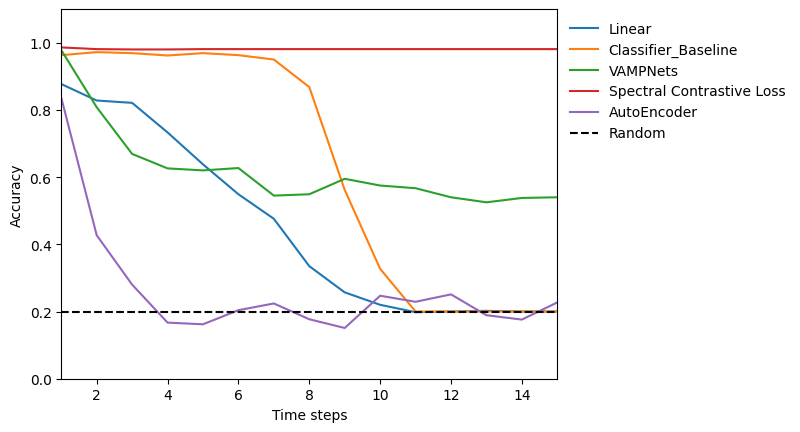

In [191]:
fig, ax = plt.subplots()
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    ax.plot(t, acc, label=model_name)

ax.axhline(1/num_digits, color='black', linestyle='--', label='Random')

ax.legend(frameon=False, bbox_to_anchor=(1, 1))
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
plt.show()

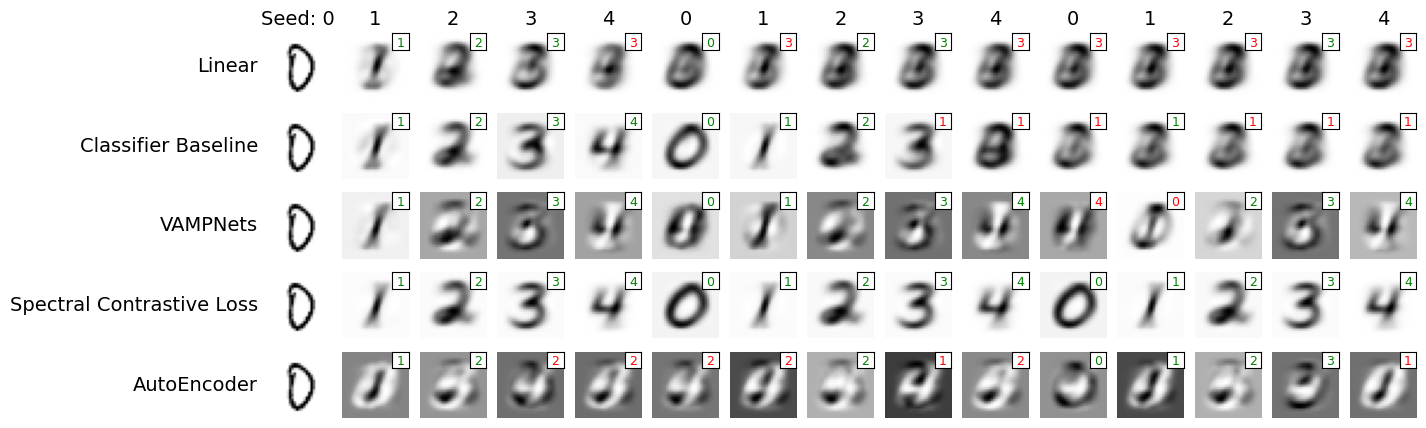

In [192]:
nun_models = len(report)
num_cols = len(report['Linear']['times'])
fig, axes = plt.subplots(nun_models, num_cols, figsize=(num_cols, nun_models), sharex=True, sharey=True)

test_seed_idx = 0
# Remove margins between columns
plt.subplots_adjust(wspace=0)

for model_idx, model_name in enumerate(report.keys()):
    # First column
    ax = axes[model_idx, 0]
    ax.imshow(test_data[test_seed_idx], cmap='Greys')
    ax.set_axis_off()
    for prediction_step in range(num_cols - 1):
        pred_label = report[model_name]['label'][prediction_step][test_seed_idx]
        true_label = (test_labels[test_seed_idx] + report[model_name]['times'][prediction_step])%num_digits
        img = report[model_name]['image'][prediction_step][test_seed_idx]
        logit = report[model_name]['logits'][prediction_step][test_seed_idx]

        # Set subplot for the current class
        ax = axes[model_idx, prediction_step + 1]

        # Plot the MNIST image
        ax.imshow(img, cmap='Greys')

        # Remove axes and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Add a white background for the subplot
        ax.set_facecolor('white')

        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.set_facecolor('white')

# Display the model names on the left of each row
for model_idx, model_name in enumerate(report.keys()):
    axes[model_idx, 0].text(-0.1, 0.5, model_name.replace('_', ' '), fontsize=14, ha='right', va='center', transform=axes[model_idx, 0].transAxes)

for class_idx in range(num_cols):
    title = (test_labels[test_seed_idx] + class_idx)%num_digits
    if class_idx == 0:
        axes[0, class_idx].set_title(f"Seed: {title}", fontsize=14)
    else:
        axes[0, class_idx].set_title(f"{title}", fontsize=14)
plt.show()

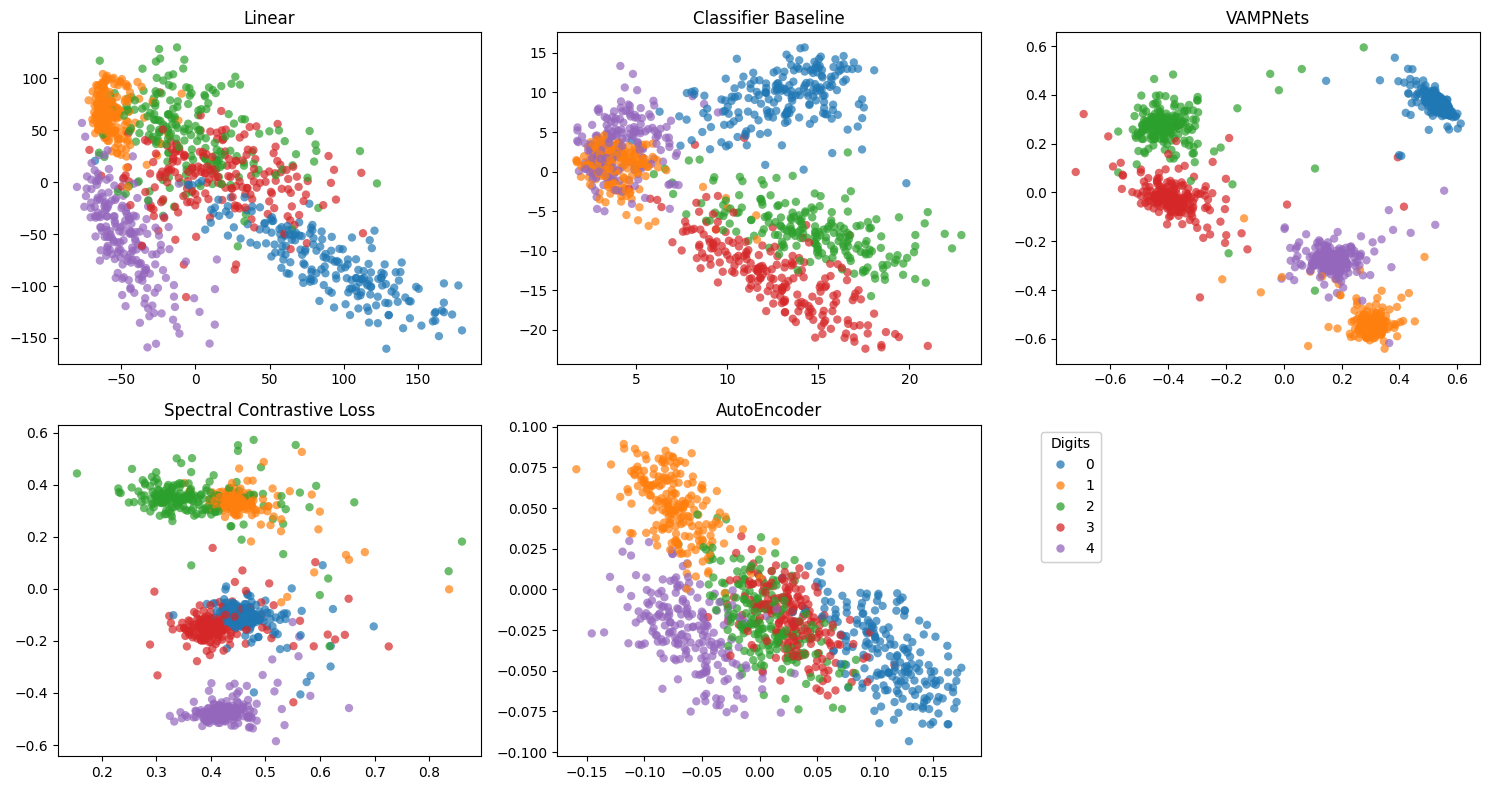

In [193]:
from kooplearn._utils import stable_topk

n_models = len(report.keys())
num_rows, num_cols = 2, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx]
    ax.title.set_text(model_name.replace('_', ' '))
    fitted_model = trained_models[model_name]['model']
    embedder = trained_models[model_name]['embedder']
    vals, lfuncs, rfuncs = fitted_model.eig(eval_right_on=embedder.transform(test_data), eval_left_on=embedder.transform(test_data))
    
    unique_vals, idx_start = np.unique(np.abs(vals), return_index=True) # returns the unique values and the index of the first occurrence of a value
    
    vals, lfuncs, rfuncs = vals[idx_start], lfuncs[:, idx_start], rfuncs[:, idx_start]
    top_vals, top_indices = stable_topk(np.abs(vals), 2)
    idx_i = top_indices[0]
    idx_j = top_indices[1]
    
    fns = lfuncs
    fn_i = fns[:, idx_i].real
    fn_j = fns[:, idx_j].real
    
    scatter = ax.scatter(fn_i, fn_j, c=test_labels, cmap='tab10', vmax=10, alpha=0.7, linewidths=0)
    
# remove last axis and add legend
ax = axes[n_models-1]
legend = ax.legend(*scatter.legend_elements(num=4), title="Digits", frameon=True, bbox_to_anchor=(1.3, 1))
ax.add_artist(legend)
fig.delaxes(axes[n_models])
    
plt.tight_layout()
plt.show()